**Objective**

This notebook implements Principal Component Analysis using eigendecomposition and applies it to the Wine dataset for dimensionality reduction and visualisation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

**Importing the data**

We are directly importing the data using Numpy. The first feature is the class label which we don't need for this exercise, hence removing it before moving forward.


In [ ]:
data = np.genfromtxt(
    "wine.csv",
    delimiter=",",
    skip_header=1
)

In [ ]:
X_raw = data[:, 1:]   # drop 'quality'
print("Shape of data:", X_raw.shape)
y = data[:, 0]

Shape of data: (177, 13)


Each row of the dataset corresponds to a single wine sample, and each column corresponds to one of the 13 measured chemical features.
$$
X_{\text{raw}} \in \mathbb{R}^{n \times d}
$$
where $n$=177 is the number of samples and $d$ = 13 is the number of features.

**Centering the data**

Centering ensures that the directions identified by PCA correspond to directions of maximum variance rather than being biased toward the mean of the data.

Define the mean of each feature:

$$
\mu_j = \frac{1}{n} \sum_{i=1}^{n} X_{\text{raw},ij}
$$

Form the mean vector:

$$
\mu = (\mu_1, \mu_2, \dots, \mu_d)
$$

Now, the centred data matrix:

$$
X = X_{\text{raw}} - \mathbf{1}\mu
$$


In [ ]:
# Centering the data
X = X_raw - np.mean(X_raw, axis=0)

**Standardising the data matrix**

Standardisation rescales each feature to have zero mean and unit variance.
This prevents features with larger numerical scales from dominating the principal components.

let
$$X \in \mathbb{R}^{n \times d}
$$

be the **centered** data matrix.

The standard daviation of feature j is defined as

$$
\sigma_j = \sqrt{\frac{1}{n-1} \sum_{i=1}^{n} X_{ij}^2}
$$

The standardized data matrix $X_{\text{std}}$ is given by

$$
X_{\text{std},ij} = \frac{X_{ij}}{\sigma_j}
$$

Equivalently, in matrix form:

$$
X_{\text{std}} = X D^{-1}
$$

where

$$
D = \mathrm{diag}(\sigma_1, \sigma_2, \ldots, \sigma_d)
$$


In [ ]:
def standardize(X):
    """
    Standardises the data matrix X column-wise.
    Each feature will have zero mean and unit variance.
    """
    n = X.shape[0]
    std = np.sqrt(np.sum(X**2, axis=0) / (n - 1))
    X_std = X / std
    return X_std

X_std = standardize(X)

**Note:** This can also be performed using Matrix multiplication.

`D_inv = np.diag(1 / std)`\
`x_std = X @ D_inv`

 but calcuting $D^{-1}$ is wasteful as it is less efficient.

- Matrix multiplication: $O(nd^2)$
- Column-wise scaling: $O(nd)$

**Covariance Matrix**

The covariance matrix is defined as

$$
C = \frac{1}{n-1} X_{\text{std}}^T X_{\text{std}}
$$

In [ ]:
cov_matrix = (X_std.T @ X_std) / (X_std.shape[0]-1)

The principal components of the dataset are given by the eigenvectors of $C$. Let $\lambda_i$ and $v_i$ denote the eigenvalues and eigenvectors of $C$.
$$
C v_i = \lambda_i v_i
$$
- $v_i$ are principal directions
- $\lambda_i$ represent variance along each direction


In [ ]:
# Eigen-decomposition of covariance matrix
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

# Sort eigenvalues and corresponding eigenvectors in descending order
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

**Cumulative explained variance**

Each eigenvalue $\lambda_i$ represents the variance explained by the $i$-th principal component.

The explained variance ratio is

$$
\text{VarRatio}_i = \frac{\lambda_i}{\sum_{j=1}^{d} \lambda_j}
$$

The cumulative explained variance is defined as

$$
\text{CumVar}_k = \sum_{i=1}^{k} \text{VarRatio}_i
$$

This quantity is used to determine the smallest number of principal components $k$
that retain a desired proportion of the total variance.


In [ ]:
# Explained variance ratio
explained_variance_ratio = eigenvalues / np.sum(eigenvalues)

#Cumulative variance
cumulative_variance = np.cumsum(explained_variance_ratio)

print("Explained variance ratio:")
print(explained_variance_ratio)

print("\nCumulative explained variance:")
print(cumulative_variance)

# Select first k principal components
k = np.argmax(cumulative_variance >= 0.8) + 1
print("Number of principal components to retain 80% variance:", k)

Explained variance ratio:
[0.35983071 0.1924128  0.1117946  0.07111109 0.06628744 0.04960367
 0.04246014 0.02697991 0.02224462 0.01898528 0.01734155 0.01295206
 0.00799613]

Cumulative explained variance:
[0.35983071 0.5522435  0.6640381  0.73514919 0.80143663 0.8510403
 0.89350044 0.92048035 0.94272497 0.96171025 0.9790518  0.99200387
 1.        ]
Number of principal components to retain 80% variance: 5


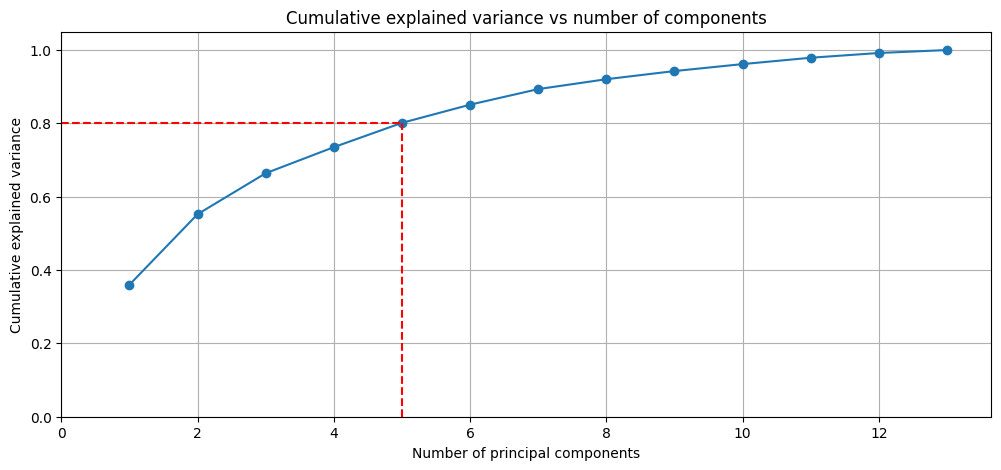

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(np.arange(1, len(cumulative_variance) + 1),
         cumulative_variance,
         marker='o')

plt.xlabel("Number of principal components")
plt.ylabel("Cumulative explained variance")
plt.title("Cumulative explained variance vs number of components")
plt.vlines(x=k, color='r', linestyle='--', label=f'k={k}',ymin=0, ymax=cumulative_variance[k-1])
plt.hlines(y=cumulative_variance[k-1], color='r', linestyle='--', label=f'k={k}', xmin=0, xmax=k)
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.grid(True)
plt.show()


**Projection onto first $k$ principal components**

After selecting $k$ principal components, the projected data is

$$
X_{\text{proj}} = X_{\text{std}} V_k
$$

Each row of $X_{\text{proj}} \in \mathbb{R}^{n \times k}$ is the representation of a data point
in the new $k$-dimensional principal component space.

In [ ]:
V_k = eigenvectors[:, :k]
X_proj = X_std @ V_k

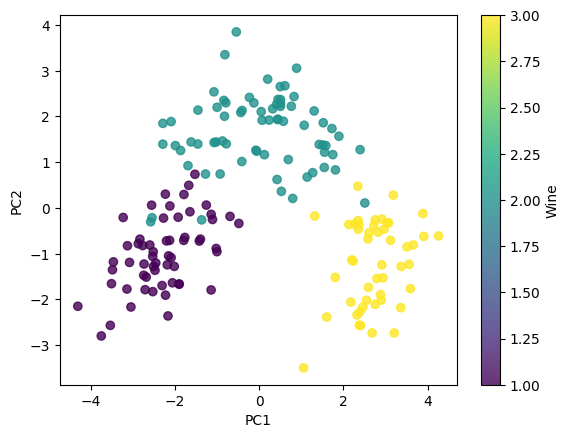

In [ ]:
plt.scatter(
    X_proj[:, 0],
    X_proj[:, 1],
    c=y,
    cmap="viridis",
    alpha=0.8
)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Wine")
plt.show()

**References**

hrdkcodes. Wine Dataset. Kaggle.

https://www.kaggle.com/datasets/hrdkcodes/wine-data/data